In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import thisnotthat as tnt
import panel as pn

zot_df = pd.read_csv('./data/zot_clean.csv')

# Convert the date columns to datetime objects
date_columns = ["Date", "Date Added", "Date Modified"]
for col in date_columns:
    zot_df[col] = pd.to_datetime(zot_df[col], errors='coerce',format="mixed")

zot_df["Publication Year"] = zot_df["Publication Year"].astype("Int64")
zot_df["Hearts"] = zot_df["Hearts"].astype("Int64")

zot_df["Manual Tags"] = zot_df["Manual Tags"].fillna("").str.split(";").apply(lambda tags: [tag.strip() for tag in tags])
zot_df["Common Tags"] = zot_df["Common Tags"].fillna("").str.split(";").apply(lambda tags: [tag.strip() for tag in tags])
zot_df["Common Tags"] = zot_df["Common Tags"].apply(lambda tags : [tag for tag in tags if tag != ""])

#dropping rows without title 
zot_df = zot_df.dropna(subset=['Title'])

# reordering the columns
first_order = ["Title", "Author", "Date", "Abstract Note","Date Added"]
new_order = first_order + [col for col in zot_df.columns.tolist() if col not in first_order]
zot_df = zot_df.reindex(columns=new_order)

# this is for lower case search
zot_df_lowercase = zot_df.copy()
zot_df_lowercase["Title Lower"] = zot_df_lowercase["Title"].str.lower()
zot_df_lowercase["Author Lower"] = zot_df_lowercase["Author"].str.lower()
zot_df_lowercase["Abstract Note Lower"] = zot_df_lowercase["Abstract Note"].str.lower()

#loading computed DR embeddings
zot_pac7 = np.array(pd.read_csv('./data/zot_pac7.csv',index_col=0))

#loading clusters
clusters = np.array(pd.read_csv("./data/clusters.csv",index_col=0))
clusters = [str(label[0]) for label in clusters]

In [2]:
zot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Title              735 non-null    object        
 1   Author             671 non-null    object        
 2   Date               735 non-null    datetime64[ns]
 3   Abstract Note      693 non-null    object        
 4   Date Added         735 non-null    datetime64[ns]
 5   Item Type          735 non-null    object        
 6   Publication Year   735 non-null    Int64         
 7   Publication Title  282 non-null    object        
 8   DOI                218 non-null    object        
 9   Url                667 non-null    object        
 10  Date Modified      735 non-null    datetime64[ns]
 11  Volume             206 non-null    float64       
 12  Publisher          332 non-null    object        
 13  Language           593 non-null    object        
 14  Library Ca

In [16]:
zot_df.columns

Index(['Title', 'Author', 'Date', 'Abstract Note', 'Date Added', 'Item Type',
       'Publication Year', 'Publication Title', 'DOI', 'Url', 'Date Modified',
       'Volume', 'Publisher', 'Language', 'Library Catalog', 'Notes',
       'Manual Tags', 'Hearts', 'Common Tags'],
      dtype='object')

In [14]:
zot_df.head()

,Title,Author,Date,Abstract Note,Date Added,Item Type,Publication Year,Publication Title,DOI,Url,...,stochastic reaction networks,stochastic rounding,tail recursion,tau-leaping,to read,transformer,uncertainty quantification,variance reduction,walk on spheres,wavelets
0,Active Learning Literature Survey,"Settles, Burr",2009-01-01,The key idea behind active learning is that a ...,2022-09-17 13:55:35,report,2009,NaN,NaN,https://minds.wisconsin.edu/handle/1793/60660,...,0,0,0,0,0,0,0,0,0,0
1,Switching Scheme: A Novel Approach for Handlin...,"Baier, Lucas; Kellner, Vincent; Kühl, Niklas; ...",2020-11-05,Machine learning models nowadays play a crucia...,2022-09-17 15:26:45,preprint,2020,NaN,NaN,http://arxiv.org/abs/2011.02738,...,0,0,0,0,0,0,0,0,0,0
2,Autoregressive based Drift Detection Method,"Mayaki, Mansour Zoubeirou A.; Riveill, Michel",2022-03-09,"In the classic machine learning framework, mod...",2022-09-17 15:33:30,preprint,2022,NaN,NaN,http://arxiv.org/abs/2203.04769,...,0,0,0,0,0,0,0,0,0,0
3,Sparsified Randomization Algorithms for large ...,"Sabelfeld, K.; Mozartova, N.",2009-01-01,Sparsiﬁed Randomization Monte Carlo (SRMC) alg...,2022-09-17 17:35:35,journalArticle,2009,Monte Carlo Methods and Applications,10.1515/MCMA.2009.015,https://www.degruyter.com/document/doi/10.1515...,...,0,0,0,0,0,0,0,0,0,0
4,Analysis of Monte Carlo accelerated iterative ...,"Benzi, Michele; Evans, Thomas M.; Hamilton, St...",2017-05-01,We consider hybrid deterministic-stochastic it...,2022-09-17 17:35:37,journalArticle,2017,Numerical Linear Algebra with Applications,10.1002/nla.2088,https://onlinelibrary.wiley.com/doi/10.1002/nl...,...,0,0,0,0,0,0,0,0,0,0


d:\program_files\miniconda\envs\zoteromap\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\isido\AppData\Local\Temp\ipykernel_25156\684562471.py:93: DeprecationWarning: TagWidget has been replaced by TagEditorWidget and will be deprecated in a future release
  tag_legend = tnt.TagWidget(zot_df["Common Tags"] + zot_df["Hearts"].fillna(0).apply(lambda x: [(str(x) if x != 0 else "?") + " likeability"]))


Launching server at http://localhost:61414


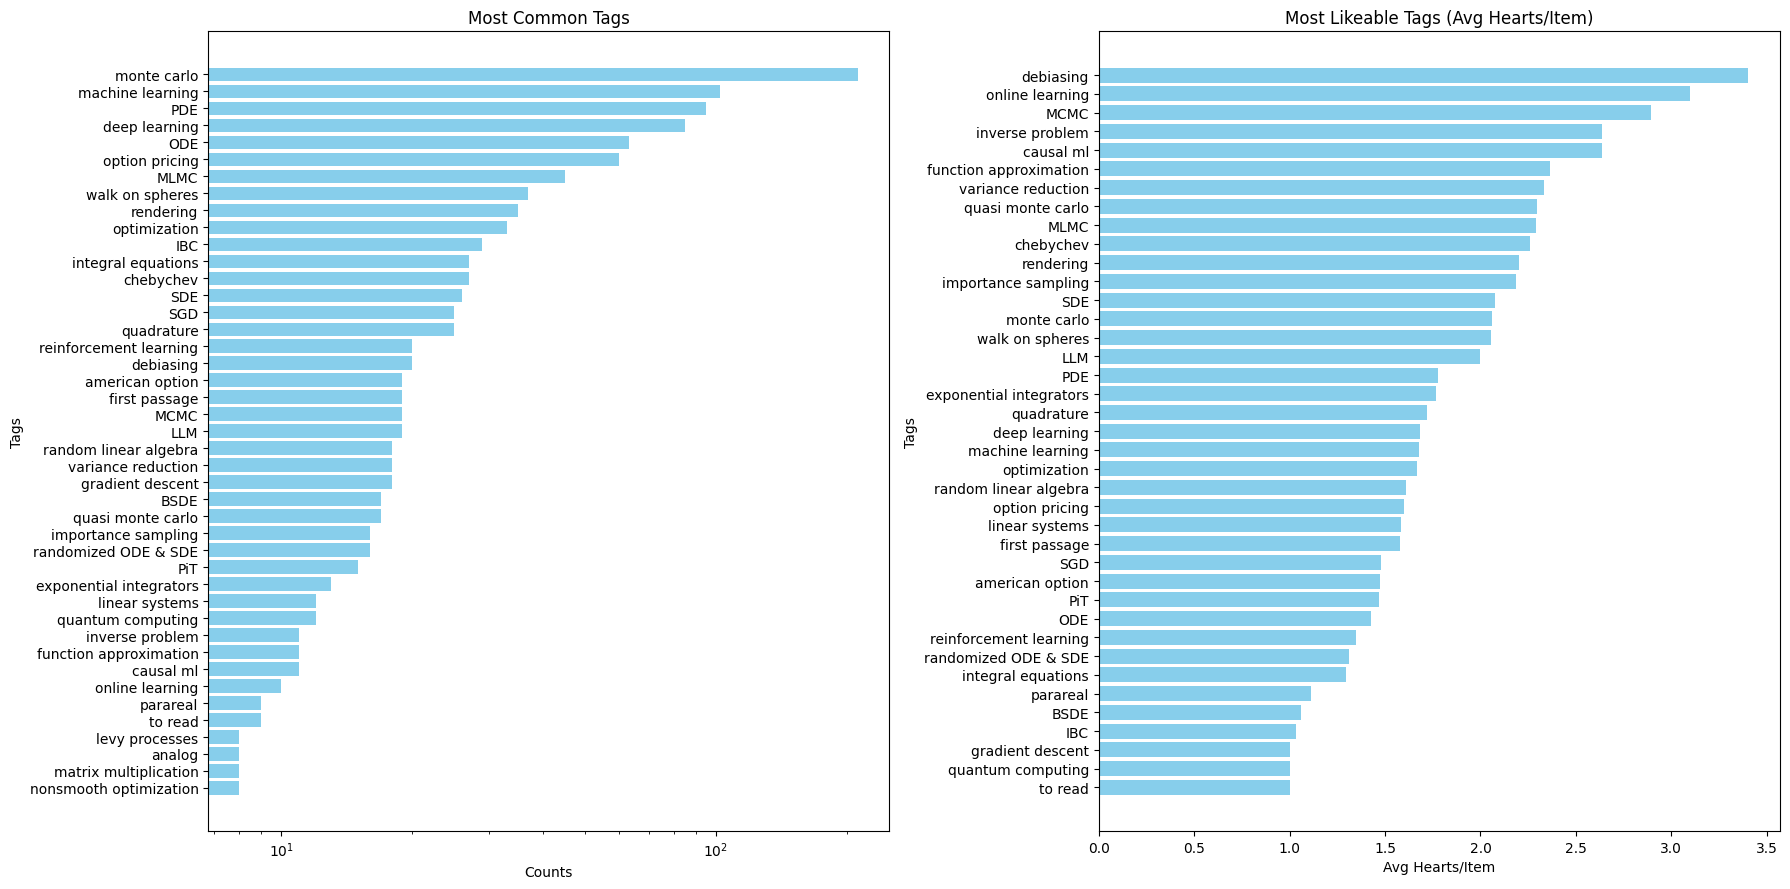

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter
import matplotlib.pyplot as plt
import panel as pn
import numpy as np

# one hot encoding of tags for labeling
mlb = MultiLabelBinarizer()

# Fit and transform the tags
onehot_encoded = mlb.fit_transform(zot_df['Manual Tags'])
onehot_df = pd.DataFrame(onehot_encoded, columns=mlb.classes_)


# tabs for pacmap viz
plots = []
label_layers = tnt.MetadataLabelLayers(
zot_pac7,
zot_pac7,
onehot_df,
hdbscan_min_cluster_size=5,
hdbscan_min_samples=5,
contamination=1e-6,
min_clusters_in_layer=5,
vector_metric="euclidean",
cluster_distance_threshold=0.0,
random_state=0,
)

p = tnt.BokehPlotPane(
        zot_pac7,
        hover_text=zot_df["Date"].dt.year.astype(str) + " " + zot_df["Title"],
        marker_size=(zot_df["Hearts"].fillna(0) + 2) / 50,
        labels = clusters, 
        show_legend=False,
        legend_location="top_right",
        sizing_mode='stretch_both',
        min_point_size=0.001,
        max_point_size=0.05,
    )

p.add_cluster_labels(label_layers,text_size_scale=35, text_layer_scale_factor=2.0,max_text_size=40,min_text_size=10)
plots.append(p)

#tabs using dates
scaler = MinMaxScaler()
for date in [zot_df["Date Added"], zot_df["Date"]]:
    date_num = date.apply(lambda x: x.timestamp()).values.reshape(-1, 1)
    date_scaled = 20 * scaler.fit_transform(date_num)
    plots.append(
        tnt.BokehPlotPane(
            np.column_stack((date_scaled, zot_pac7[:, 0])),
            hover_text=zot_df["Date"].dt.year.astype(str) + " " + zot_df["Title"],
            marker_size=(zot_df["Hearts"].fillna(0) + 2) / 50,
            labels = clusters, 
            show_legend=False,
            legend_location="top_right",
            sizing_mode='stretch_both',
            min_point_size=0.001,
            max_point_size=0.05,
        )
    )
# data view tab
data_view = tnt.SimpleDataPane(
    zot_df,
    sizing_mode="stretch_both", max_rows=9999, max_cols=50)

data_view_simple = tnt.SimpleDataPane(
    zot_df[["Title", "Author", "Date", "Abstract Note"]],
    sizing_mode="stretch_both", max_rows=9999, max_cols=50)

# linking the tabs
for i in range(1, len(plots)):
    plots[i].link(
        plots[0],
        selected="selected",
        bidirectional=True
    )

data_view.link(
    plots[0],
    selected="selected",
    bidirectional=True
)

data_view_simple.link(
    plots[0],
    selected="selected",
    bidirectional=True
)
# tag selector
tag_legend = tnt.TagWidget(zot_df["Common Tags"] + zot_df["Hearts"].fillna(0).apply(lambda x: [(str(x) if x != 0 else "?") + " likeability"]))
tag_legend.link_to_plot(plots[0])

tabs = [pn.Row(plot, tag_legend, name=name) for plot, name in zip(plots, ["pac7", "Date Added", "Date"])]


# tags stats tab, just a plot
# Flatten the list of tags
all_tags = [tag for sublist in zot_df["Manual Tags"] for tag in sublist if tag != ""]

# Count the occurrences of each tag
tag_counts = Counter(all_tags)

total_tags = sum(tag_counts.values())

# Filter out tags that are less than 0.5% of the total
filtered_tag_counts = {tag: count for tag, count in tag_counts.items() if count / total_tags >= 0.005}

# Sort the tags by frequency
sorted_tag_counts = dict(sorted(filtered_tag_counts.items(), key=lambda item: item[1], reverse=True))

# Create a figure with 2 subplots
plt.figure(figsize=(18, 9))

# First subplot: Most Common Tags
plt.subplot(1, 2, 1)
plt.barh(list(sorted_tag_counts.keys())[::-1], list(sorted_tag_counts.values())[::-1], color='skyblue')
plt.xlabel('Counts')
plt.ylabel('Tags')
plt.title('Most Common Tags')
plt.xscale('log')
plt.tight_layout()

# Flatten the list of tags and their corresponding hearts
all_tags = [(tag, hearts) for tags, hearts in zip(zot_df["Manual Tags"], zot_df["Hearts"].fillna(1)) for tag in tags if tag != ""]

# Sum the hearts for each tag
tag_hearts = Counter()
for tag, hearts in all_tags:
    tag_hearts[tag] += hearts

# Divide the total hearts by the frequency of each tag
weighted_tag_counts = {tag: tag_hearts[tag] / count for tag, count in tag_counts.items() if count >= 9}

# Sort the tags by frequency
sorted_tag_counts = dict(sorted(weighted_tag_counts.items(), key=lambda item: item[1], reverse=True))

# Second subplot: Most Likeable Tags (Avg Hearts/Item)
plt.subplot(1, 2, 2)
plt.barh(list(sorted_tag_counts.keys())[::-1], list(sorted_tag_counts.values())[::-1], color='skyblue')
plt.xlabel('Avg Hearts/Item')
plt.ylabel('Tags')
plt.title('Most Likeable Tags (Avg Hearts/Item)')
plt.tight_layout()

# Convert the plot to a Panel object
tag_plot = pn.pane.Matplotlib(plt.gcf(), sizing_mode='stretch_both')

app = pn.Tabs(
    *tabs,
    pn.Column(data_view_simple, name="data simple"),
    pn.Column(tag_plot, name="tags stats"),
    pn.Column(data_view, name="data all"))

# add simple search
simplesearch = tnt.SimpleSearchWidget(plots[0], raw_dataframe=zot_df_lowercase)
app = pn.Column(simplesearch, app)

pn.serve(app)